In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os 
import wave

.\OAF_angry


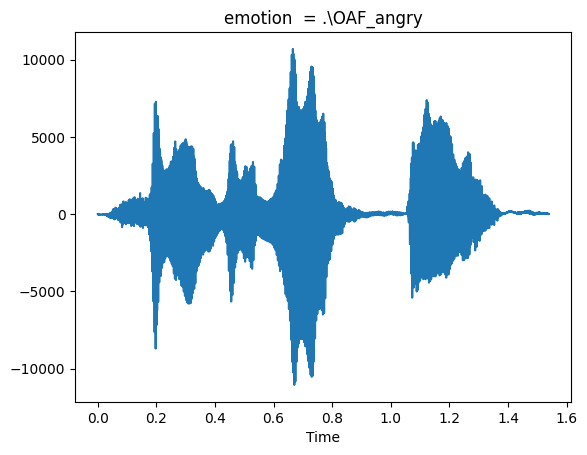

.\OAF_angry_images


Error: file does not start with RIFF id

In [24]:

for root, dirs, files in os.walk('.'):
    if root == '.':
        continue
    print(root)
    for file in files[:1]:
        raw = wave.open(os.path.join(root, file))
      

        signal = raw.readframes(-1) 
        signal = np.frombuffer(signal, dtype ="int16") 
        
        # gets the frame rate 
        f_rate = raw.getframerate() 

        time = np.linspace( 
            0, # start 
            len(signal) / f_rate, 
            num = len(signal) 
        ) 
    
        # using matplotlib to plot 
        # creates a new figure 
        plt.figure(1) 
        
        # title of the plot 
        plt.title(f"emotion  = {root}") 
        
        # label of x-axis 
        plt.xlabel("Time") 
        
        # actual plotting 
        plt.plot(time, signal) 
        
        # shows the plot  
        # in new window 
        plt.show() 
    

### CREATING THE IMAGES FOR CNN

In [ ]:
# cnn modeline uygun bir şekilde kaydetmek için axislerin olmadığı bir şekilde kaydetmemiz gerekiyor.
def save_plot(x,y,save_path):
    fig, ax = plt.subplots()
    ax.plot(x, y)

    # Remove axis, ticks, labels
    ax.axis('off')

    # Save without extra borders
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()


In [21]:
for root, dirs, files in os.walk('.'):
    if root == '.':
        continue

    os.makedirs(root+"_images", exist_ok=True) # her duygu için yeni bir klasör açıyoruz.
    for file in files:
        raw = wave.open(os.path.join(root, file))
      

        signal = raw.readframes(-1) 
        signal = np.frombuffer(signal, dtype ="int16") 
        
        # gets the frame rate 
        f_rate = raw.getframerate() 

        time = np.linspace( 
            0, 
            len(signal) / f_rate, 
            num = len(signal) 
        ) 
        save_plot(time, signal, os.path.join(root+"_images", file.split(".")[0]+".png"))
    

In [25]:
from PIL import Image
from tensorflow.keras.applications.resnet50 import preprocess_input

image_size = (224, 224)  # Required input size for ResNet50

image_data = []
labels = []

for root, dirs, files in os.walk('.'):
    if not root.endswith('_images'):
        continue

    label = os.path.basename(root).replace('_images', '')

    for file in files:
        if not file.endswith('.png'):
            continue

        img_path = os.path.join(root, file)

        # Load, resize, convert to array
        img = Image.open(img_path).convert('RGB')
        img = img.resize(image_size)
        img_array = np.array(img).astype('float32')

        # Preprocess for ResNet50
        img_array = preprocess_input(img_array)

        image_data.append(img_array)
        labels.append(label)

X = np.array(image_data)
y = np.array(labels)

print("X shape:", X.shape)  # (num_samples, 224, 224, 3)
print("y shape:", y.shape)


X shape: (600, 224, 224, 3)
y shape: (600,)


In [27]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_onehot = to_categorical(y_encoded)


base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(y_onehot.shape[1], activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Freeze base layers for transfer learning
for layer in base_model.layers:
    layer.trainable = False

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


94765736/94765736 [==============================] - 9s 0us/step


In [28]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y_onehot, 
    test_size=0.2,      
    random_state=42)  


In [29]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)


Epoch 1/10
15/15 [==============================] - 23s 1s/step - loss: 1.1022 - accuracy: 0.5813 - val_loss: 0.6232 - val_accuracy: 0.7000
Epoch 2/10
15/15 [==============================] - 20s 1s/step - loss: 0.3687 - accuracy: 0.8687 - val_loss: 0.2926 - val_accuracy: 0.9000
Epoch 3/10
15/15 [==============================] - 20s 1s/step - loss: 0.2249 - accuracy: 0.9229 - val_loss: 0.2257 - val_accuracy: 0.9167
Epoch 4/10
15/15 [==============================] - 20s 1s/step - loss: 0.1702 - accuracy: 0.9500 - val_loss: 0.2128 - val_accuracy: 0.9250
Epoch 5/10
15/15 [==============================] - 20s 1s/step - loss: 0.1211 - accuracy: 0.9708 - val_loss: 0.1584 - val_accuracy: 0.9500
Epoch 6/10
15/15 [==============================] - 20s 1s/step - loss: 0.0937 - accuracy: 0.9812 - val_loss: 0.1347 - val_accuracy: 0.9583
Epoch 7/10
15/15 [==============================] - 20s 1s/step - loss: 0.0795 - accuracy: 0.9833 - val_loss: 0.1289 - val_accuracy: 0.9500
Epoch 8/10
15/15 [==

In [31]:
model

### NEW PREDICTION 

In [32]:
def wav_to_image_array(wav_path, image_size=(224, 224)):
    # Load and process audio
    raw = wave.open(wav_path)
    signal = raw.readframes(-1)
    signal = np.frombuffer(signal, dtype='int16')
    f_rate = raw.getframerate()

    time = np.linspace(0, len(signal) / f_rate, num=len(signal))

    # Plot waveform without axis
    fig, ax = plt.subplots()
    ax.plot(time, signal)
    ax.axis('off')
    fig.tight_layout(pad=0)

    # Save plot to an in-memory image (no disk I/O)
    from io import BytesIO
    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    buf.seek(0)

    # Open image with PIL, resize, convert to array
    img = Image.open(buf).convert('RGB')
    img = img.resize(image_size)
    img_array = np.array(img).astype('float32')
    img_array = preprocess_input(img_array)  # ResNet50 specific
    buf.close()

    return img_array


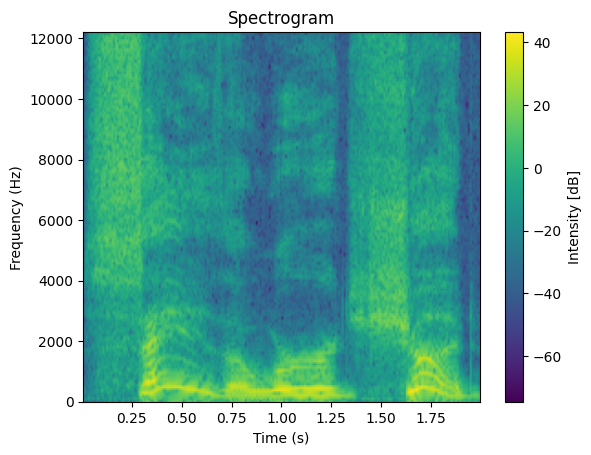

In [43]:
new_wav_path = "OAF_happy\OAF_should_happy.wav"

from scipy.io import wavfile
from scipy.signal import spectrogram

def plot_spectrogram(path):
    sample_rate, samples = wavfile.read(path)
    f, t, Sxx = spectrogram(samples, fs=sample_rate)
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')  # Convert to dB
    plt.title("Spectrogram")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.colorbar(label='Intensity [dB]')
    plt.show()

plot_spectrogram(new_wav_path)

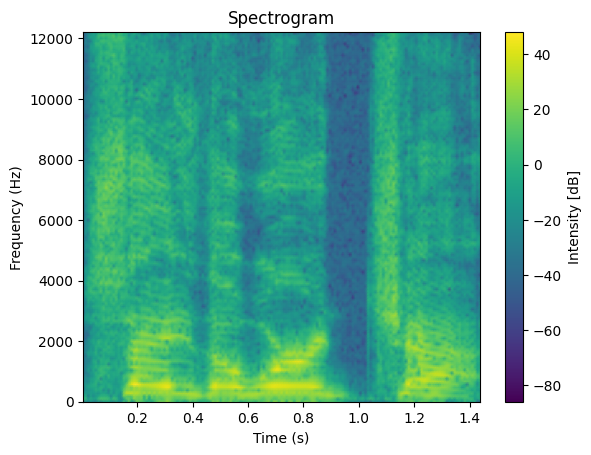

In [46]:
new_wav_path = "OAF_angry\OAF_chat_angry.wav"

from scipy.io import wavfile
from scipy.signal import spectrogram

def plot_spectrogram(path):
    sample_rate, samples = wavfile.read(path)
    f, t, Sxx = spectrogram(samples, fs=sample_rate)
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')  # Convert to dB
    plt.title("Spectrogram")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.colorbar(label='Intensity [dB]')
    plt.show()

plot_spectrogram(new_wav_path)